<a href="https://colab.research.google.com/github/dsevero/generative-models/blob/master/experiments/GAN/notebooks/goodfellow_2014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Nets (Goodfellow 2014)
https://arxiv.org/pdf/1406.2661.pdf

In [0]:
%matplotlib inline

In [0]:
# necessary for autograd compatibility
!pip install scipy==1.1.0 -q

# update tensorflow
!pip install tensorflow==2.0.0b1 -q

In [0]:
import autograd.numpy as np
import autograd.numpy.random as npr
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from autograd import grad
from autograd.misc import flatten
from scipy.stats import norm
    

warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    return plt.axis('off')

## Definitions and Tests

In [0]:
# reference: 
# https://github.com/HIPS/autograd/blob/master/examples/generative_adversarial_net.py

def relu(x):       
    return np.maximum(0, x)

def sigmoid(x):    
    return 0.5 * (np.tanh(x) + 1.0)

def logsigmoid(x): 
    return x - np.logaddexp(0, x)

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples,
       one for each layer in the net."""
    return [(scale * rs.randn(m, n),   # weight matrix
             scale * rs.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

def batch_normalize(activations):
    mbmean = np.mean(activations, axis=0, keepdims=True)
    return (activations - mbmean) / (np.std(activations, axis=0, keepdims=True) + 1)

def neural_net_predict(params, inputs, use_batch_norm=True):
    """Params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix."""
    inpW, inpb = params[0]
    inputs = relu(np.dot(inputs, inpW) + inpb)
    for W, b in params[1:-1]:
        outputs = np.dot(inputs, W) + b
        if use_batch_norm:
            outputs = batch_normalize(outputs)
        inputs = relu(outputs)
    outW, outb = params[-1]
    outputs = np.dot(inputs, outW) + outb
    return outputs

def generate_from_noise(gen_params, num_samples, noise_dim, rs):
    noise = rs.rand(num_samples, noise_dim)
    samples = neural_net_predict(gen_params, noise)
    return sigmoid(samples)

In [0]:
params = 5*((np.eye(3), np.zeros(3)),)
x = npr.randn(9).reshape((3,3))


assert (batch_normalize([0, 0, 0]) == [0, 0, 0]).all()
assert (batch_normalize([-1, 1]) == [-0.5, 0.5]).all()
assert (batch_normalize([[-1, 1], [-2, 2]]) == [[1/3, -1/3], [-1/3, 1/3]]).all()

assert (neural_net_predict(params, x, False) == relu(x)).all()

## 5 Experiments (MNIST)

In [10]:
# Training parameters
param_scale = 0.001
batch_size = 100 # must divide 70_000.
num_epochs = 50
num_batches = int(70_000/batch_size)


# Load, concatenate and reshape the data.
# Here we don't distinguish between train and test.
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
images = (np.concatenate((train_images, test_images))
            .reshape((num_batches, batch_size, 28, 28)) / 255)

# Model hyper-parameters
noise_dim = 10
gen_layer_sizes = [noise_dim, 200, 784]
dsc_layer_sizes = [784, 200, 1]

# Initialize NN params. for G and D
init_gen_params = init_random_params(param_scale, gen_layer_sizes)
init_dsc_params = init_random_params(param_scale, dsc_layer_sizes)

print('images.shape:', images.shape)

images.shape: (700, 100, 28, 28)


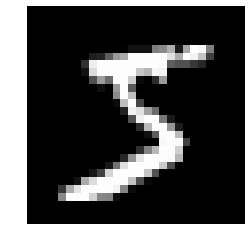

In [11]:
show_image(images[0, 0]);